In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-time-series-data/time-series-19-covid-combined.csv


In [2]:
df= pd.read_csv("/kaggle/input/covid-19-time-series-data/time-series-19-covid-combined.csv")
df.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
1,2020-01-23,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
2,2020-01-24,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
3,2020-01-25,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
4,2020-01-26,Afghanistan,NaN,33.93911,67.709953,0,0.0,0


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72090 entries, 0 to 72089
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            72090 non-null  object 
 1   Country/Region  72090 non-null  object 
 2   Province/State  21870 non-null  object 
 3   Lat             72090 non-null  float64
 4   Long            72090 non-null  float64
 5   Confirmed       72090 non-null  int64  
 6   Recovered       68310 non-null  float64
 7   Deaths          72090 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 4.4+ MB


In [5]:
df.isnull().sum()

Date                  0
Country/Region        0
Province/State    50220
Lat                   0
Long                  0
Confirmed             0
Recovered          3780
Deaths                0
dtype: int64

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
1,2020-01-23,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
2,2020-01-24,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
3,2020-01-25,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
4,2020-01-26,Afghanistan,NaN,33.93911,67.709953,0,0.0,0


In [7]:
df['Province/State'] = df['Province/State'].fillna('Unknown')
df['Recovered'] = df['Recovered'].fillna(0)

In [8]:
df_grouped = df.groupby(['Date', 'Country/Region']).agg({
    "Confirmed" : 'sum',
    "Recovered" : 'sum',
    'Deaths' : 'sum'
}).reset_index()

df_grouped.head()

,Date,Country/Region,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0.0,0
1,2020-01-22,Albania,0,0.0,0
2,2020-01-22,Algeria,0,0.0,0
3,2020-01-22,Andorra,0,0.0,0
4,2020-01-22,Angola,0,0.0,0


<ipython-input-9-8d6c7e227358>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_grouped, x='Date', y='Confirmed', ci=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


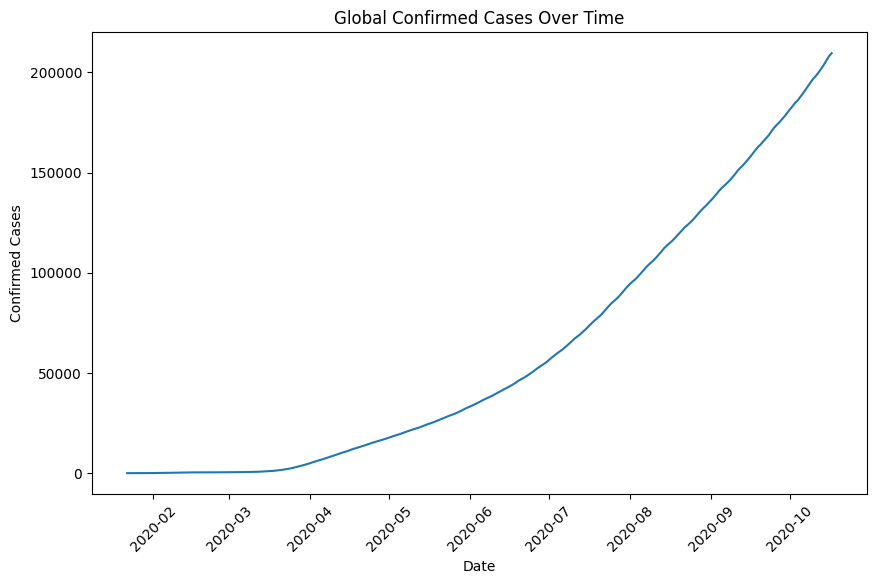

In [9]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_grouped, x='Date', y='Confirmed', ci=None)
plt.title("Global Confirmed Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

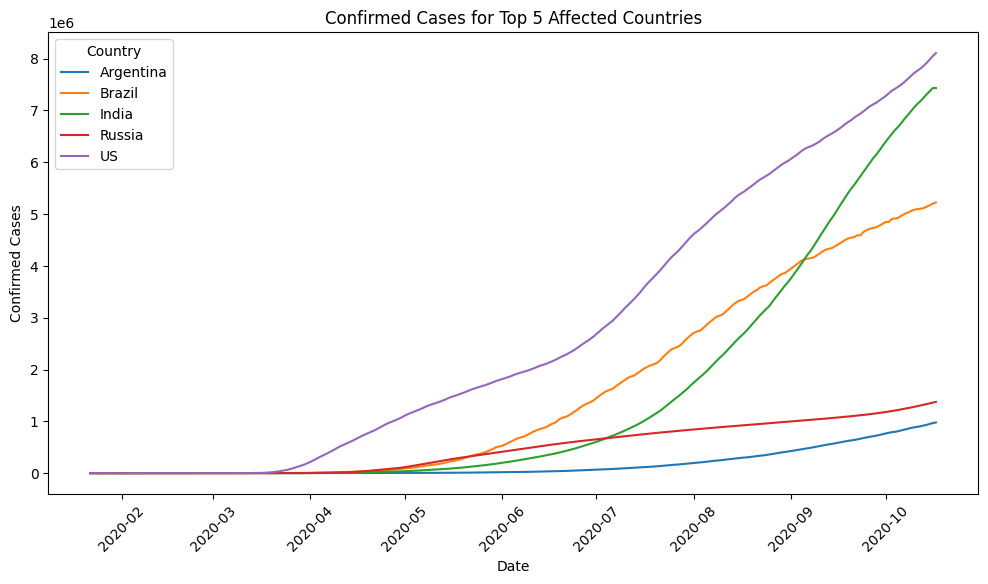

In [10]:
top_countries = df_grouped.groupby('Country/Region')['Confirmed'].max().nlargest(5).index

df_top = df_grouped[df_grouped['Country/Region'].isin(top_countries)]

plt.figure(figsize=(12,6))
sns.lineplot(data=df_top, x='Date', y='Confirmed', hue='Country/Region')
plt.title('Confirmed Cases for Top 5 Affected Countries')
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.legend(title ='Country')
plt.xticks(rotation=45)
plt.show()

<ipython-input-11-b0a0fc78aa16>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_grouped, x='Date', y='Confirmed', label="Confirmed Cases", ci=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-11-b0a0fc78aa16>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_grouped, x='Date', y='Deaths', label="Deaths", ci=None, color='red')
/usr/local/lib/python3.10/dist-pack

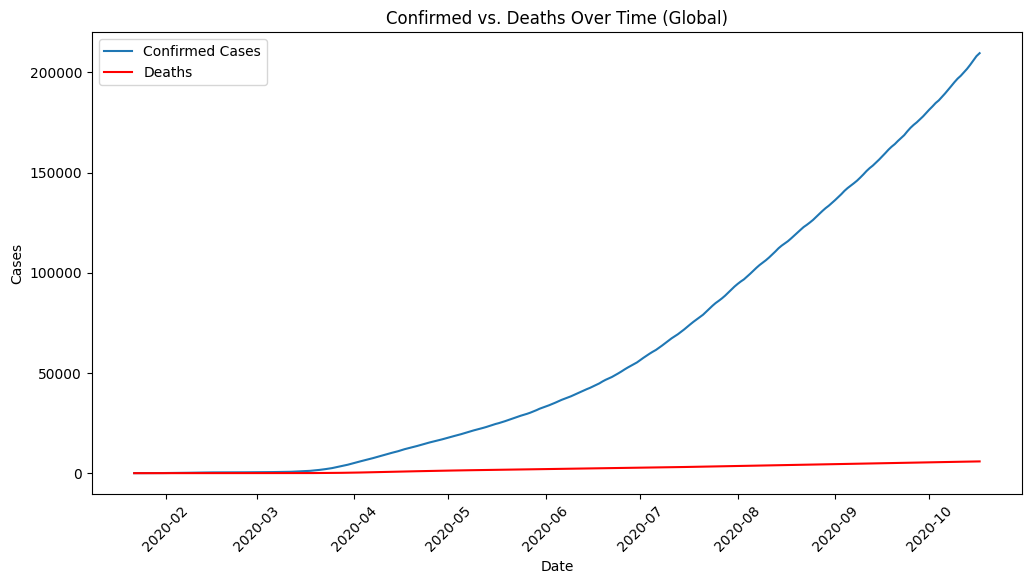

In [11]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_grouped, x='Date', y='Confirmed', label="Confirmed Cases", ci=None)
sns.lineplot(data=df_grouped, x='Date', y='Deaths', label="Deaths", ci=None, color='red')
plt.title("Confirmed vs. Deaths Over Time (Global)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [12]:
df_grouped['New Confirmed'] = df_grouped.groupby('Country/Region')['Confirmed'].diff().fillna(0)
df_grouped['New Recovered'] = df_grouped.groupby('Country/Region')['Recovered'].diff().fillna(0)
df_grouped['New Deaths'] = df_grouped.groupby('Country/Region')['Deaths'].diff().fillna(0)

df_grouped.head()

,Date,Country/Region,Confirmed,Recovered,Deaths,New Confirmed,New Recovered,New Deaths
0,2020-01-22,Afghanistan,0,0.0,0,0.0,0.0,0.0
1,2020-01-22,Albania,0,0.0,0,0.0,0.0,0.0
2,2020-01-22,Algeria,0,0.0,0,0.0,0.0,0.0
3,2020-01-22,Andorra,0,0.0,0,0.0,0.0,0.0
4,2020-01-22,Angola,0,0.0,0,0.0,0.0,0.0


In [13]:
features = ['New Confirmed', 'New Recovered', 'New Deaths']
X= df_grouped[features]
y= df_grouped['Confirmed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40824, 3), (10206, 3), (40824,), (10206,))

In [14]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [15]:
model= Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1276/1276 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 65944408064.0000 - val_loss: 40601358336.0000
Epoch 2/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 49390436352.0000 - val_loss: 45646012416.0000
Epoch 3/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 48531435520.0000 - val_loss: 40317390848.0000
Epoch 4/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 39994757120.0000 - val_loss: 39684550656.0000
Epoch 5/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 45001687040.0000 - val_loss: 42238058496.0000
Epoch 6/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 44963123200.0000 - val_loss: 40417509376.0000
Epoch 7/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 53463793664.0000 - val_loss: 46288732160.0000
Epoch 8/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 48568741888.0000 - val_loss: 39718780928.0000
Epoch 9/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 43392217088.0000 - val_loss: 45272993792.0000
Epoch 10/10
1276/1276 ━━━━━━━━━━━━━━━━

In [16]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error : {mae}")

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Absolute Error : 35844.74527023588


In [17]:
from sklearn.preprocessing import MinMaxScaler

# Initialize Scaler
scaler = MinMaxScaler()

# Scale training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
from tensorflow.keras.layers import Dropout

# Rebuild Model with Dropout
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),  # Helps prevent overfitting
    LSTM(50, activation='relu', return_sequences=False),
    Dense(1)
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model Again
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1276/1276 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 140432015360.0000 - val_loss: 121723232256.0000
Epoch 2/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 126190870528.0000 - val_loss: 92553027584.0000
Epoch 3/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 94782341120.0000 - val_loss: 52633100288.0000
Epoch 4/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 51104227328.0000 - val_loss: 43694104576.0000
Epoch 5/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 57198374912.0000 - val_loss: 43050418176.0000
Epoch 6/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 62140952576.0000 - val_loss: 52074602496.0000
Epoch 7/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 62521679872.0000 - val_loss: 52644380672.0000
Epoch 8/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 63219187712.0000 - val_loss: 40626466816.0000
Epoch 9/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 58492796928.0000 - val_loss: 41731690496.0000
Epoch 10/10
1276/1276 ━━━━━━━━━━━━━

In [19]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error : {mae}")

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Absolute Error : 4645361886.489243


In [20]:
from sklearn.ensemble import RandomForestRegressor

# Train a simple model to check feature importance
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Display feature importance
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")


New Confirmed: 0.7910
New Recovered: 0.1369
New Deaths: 0.0721


In [21]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
from xgboost import XGBRegressor

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import mean_absolute_error
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost Mean Absolute Error: {mae_xgb}")


XGBoost Mean Absolute Error: 32553.654971479133


In [23]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],   # Increase tree estimators
    'learning_rate': [0.01, 0.05, 0.1],  # Try different learning rates
    'max_depth': [3, 5, 7],   # Try different tree depths
    'subsample': [0.8, 1.0],  # Fraction of data used per tree
}

# Perform Grid Search
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


In [24]:
best_xgb = XGBRegressor(learning_rate=0.05, max_depth=7, n_estimators=300, subsample=1.0)
best_xgb.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
y_pred_best = best_xgb.predict(X_test_scaled)
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f"Optimized XGBoost MAE: {mae_best}")


Optimized XGBoost MAE: 30889.67515064907


In [26]:
y_train_pred = best_xgb.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, y_train_pred)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {mae_best}")


Train MAE: 27358.131833611154
Test MAE: 30889.67515064907


In [27]:
best_xgb = XGBRegressor(
    learning_rate=0.05,
    max_depth=7,
    n_estimators=300,
    subsample=1.0,
    reg_alpha=1,  # L1 Regularization to reduce complexity
    reg_lambda=1   # L2 Regularization to reduce overfitting
)

best_xgb.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
df_grouped['Active_Cases'] = df_grouped['Confirmed'] - df_grouped['Recovered'] - df_grouped['Deaths']
df_grouped['Recovery_Rate'] = df_grouped['Recovered'] / df_grouped['Confirmed']
df_grouped['Death_Rate'] = df_grouped['Deaths'] / df_grouped['Confirmed']
df_grouped = df_grouped.fillna(0)  # Handle NaN values


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(1)
])

# Compile Model
lstm_model.compile(optimizer='adam', loss='mae')

# Train Model
lstm_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1276/1276 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 59490.9141 - val_loss: 57751.3711
Epoch 2/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 62686.4961 - val_loss: 33467.3281
Epoch 3/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 34602.6367 - val_loss: 33295.4180
Epoch 4/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 35165.1875 - val_loss: 33223.1211
Epoch 5/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 33103.7852 - val_loss: 33119.1953
Epoch 6/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 36940.2930 - val_loss: 33709.9453
Epoch 7/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 36801.9727 - val_loss: 34053.9727
Epoch 8/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 35790.8750 - val_loss: 33355.2109
Epoch 9/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 35965.3945 - val_loss: 33788.6875
Epoch 10/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 36203.2266 - val_loss: 35179.4961
Epoch 11/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/

In [30]:
# Make Predictions
y_pred_lstm = lstm_model.predict(X_test_scaled)

# Compute MAE
from sklearn.metrics import mean_absolute_error
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f"LSTM Mean Absolute Error: {mae_lstm}")


319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Mean Absolute Error: 33395.48444621665


In [31]:
lstm_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 35148.8320 - val_loss: 33304.2109
Epoch 2/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 34023.2305 - val_loss: 33230.1758
Epoch 3/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 36369.3086 - val_loss: 33117.9453
Epoch 4/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 36320.5586 - val_loss: 33065.9492
Epoch 5/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 35051.9766 - val_loss: 33179.7109
Epoch 6/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 35139.8906 - val_loss: 33532.2734
Epoch 7/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 34630.6289 - val_loss: 33591.0703
Epoch 8/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 34900.8320 - val_loss: 33230.9375
Epoch 9/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 35684.6094 - val_loss: 33145.4219
Epoch 10/50
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 35447.1211 - val_loss: 33158.9062
Epoch 11/50
1276/1276 ━━━━━━━━━━━━━━━━━

In [32]:
# Make Predictions with LSTM
y_pred_lstm = lstm_model.predict(X_test_scaled)

# Compute MAE
from sklearn.metrics import mean_absolute_error
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f"LSTM Mean Absolute Error: {mae_lstm}")


319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM Mean Absolute Error: 33279.29671395294


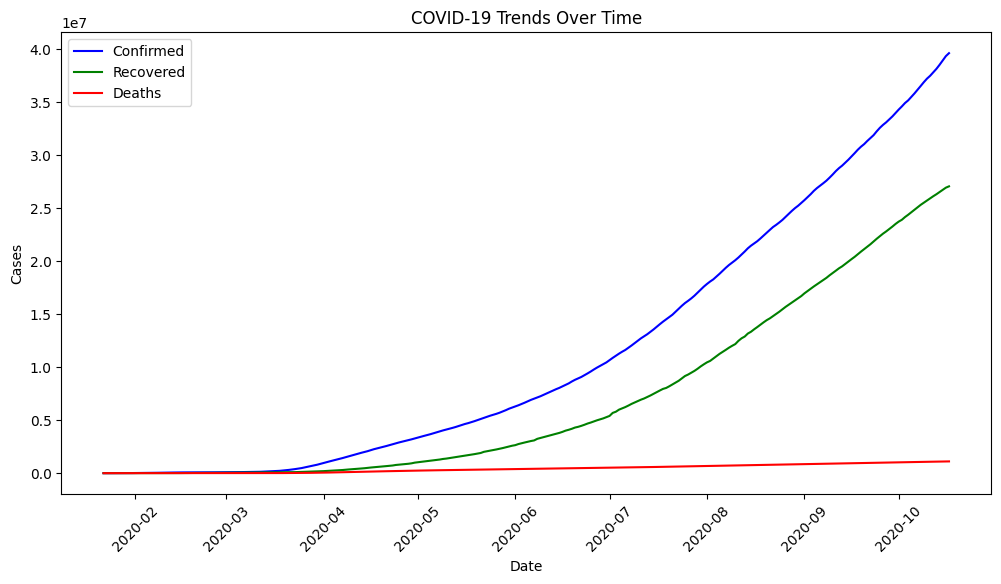

In [33]:
plt.figure(figsize=(12,6))
plt.plot(df_grouped.groupby("Date")["Confirmed"].sum(), label="Confirmed", color='blue')
plt.plot(df_grouped.groupby("Date")["Recovered"].sum(), label="Recovered", color='green')
plt.plot(df_grouped.groupby("Date")["Deaths"].sum(), label="Deaths", color='red')
plt.title("COVID-19 Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


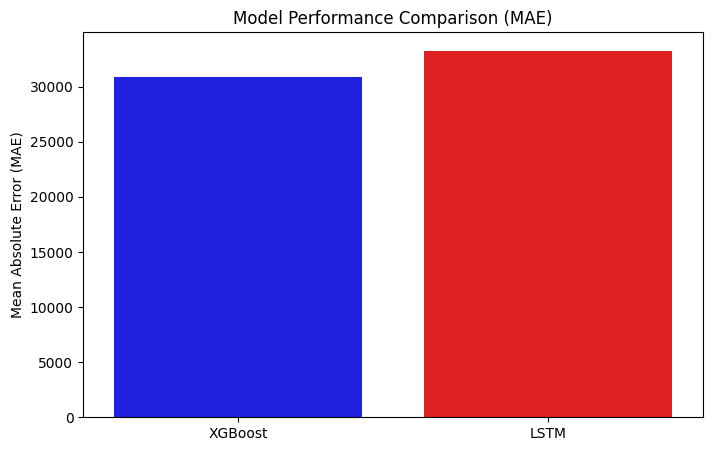

In [34]:
models = ["XGBoost", "LSTM"]
mae_values = [mae_best, mae_lstm]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=mae_values, palette=["blue", "red"])
plt.title("Model Performance Comparison (MAE)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()
